In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights
from tools import zero_balanced_weights


## Step 1: Implementing a Two Layer Deep Linear Network in Pytorch

In [1]:
class LinearNetwork:
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1 = None, init_w2 = None):

        if init_w1 is not None and init_w2 is not None:
            self.W1 = init_w1 
            self.W2 = init_w2
        else:
            self.W1 = np.random.randn(hidden_dim, in_dim)
            self.W2 = np.random.randn(out_dim, hidden_dim)

    def forward(self, x): 
        self.z = self.W2 @ self.W1 @ x
        return self.z

    def backward(self, x, y, learning_rate):

        self.forward(x)
        dW1 = 1/x.shape[1] *self.W2.T @ (self.z-y) @ x.T 
        dW2 = 1/x.shape[1] * (self.z - y) @ x.T @ self.W1.T

        self.W2 -= learning_rate * dW2
        self.W1 -= learning_rate * dW1


    def train(self, X_train, Y_train, epochs, learning_rate):
        w1s = []
        w2s = []
        print('X_train shape: ', X_train.shape)
        print('Y_train shape: ', Y_train.shape)
        losses = []
        print('epochs: ', epochs)
        for _ in range(epochs):
            loss = np.mean((self.forward(X_train) - Y_train) ** 2)
            losses.append(loss)
            w1s.append(self.W1)
            w2s.append(self.W2)
            self.backward(X_train, Y_train, learning_rate)
            # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

        return w1s, w2s, losses

# Step 2: Implement Analytical Solution from Paper

In [2]:
class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 


## Implement Code to generate whitened data + balanced weights

In [31]:
def reshape_matrix(input_matrix, new_shape):

    old_shape = input_matrix.shape
    

    if new_shape[0] > old_shape[0]:

        new_matrix = np.vstack((input_matrix, np.zeros((new_shape[0] - old_shape[0], old_shape[1]))))
    elif new_shape[0] < old_shape[0]:

        new_matrix = input_matrix[:new_shape[0], :]
    else:
        new_matrix = input_matrix
    
    if new_shape[1] > old_shape[1]:
        new_matrix = np.hstack((new_matrix, np.zeros((new_shape[0], new_shape[1] - old_shape[1]))))
    elif new_shape[1] < old_shape[1]:
        new_matrix = new_matrix[:, :new_shape[1]]
    
    return new_matrix

In [30]:
def balanced_weights(in_dim, hidden_dim, out_dim):

    ##TODO: change this
    sigma = 1

    
    U, S, V = np.linalg.svd(np.random.randn(hidden_dim, hidden_dim))
    r = U @ V.T

    w1 = sigma * np.random.randn(hidden_dim, in_dim)
    w2 = sigma * np.random.randn(out_dim, hidden_dim)

    U_, S_, V_ = np.linalg.svd(w2 @ w1)
    s = np.sqrt(np.diag(S_))

    lmda = np.trace(w2 @ w1) / hidden_dim

    factor = (- lmda + np.sqrt(lmda ** 2 + 4 * s ** 2)) / 2

    s_2 = np.sqrt(np.diag(np.diag(factor)))

    s2_reshaped = reshape_matrix(s_2, (out_dim, hidden_dim))

    s_1 = np.diag(np.diag(s) / np.diag(s_2))

    s1_reshaped = reshape_matrix(s_1, (hidden_dim, in_dim))

    S_test = s2_reshaped @ s1_reshaped

    w1_out = r @ s1_reshaped @ V_.T 

    w2_out = U_ @ s2_reshaped @ r.T

    q = w1_out @ w1_out.T - w2_out.T @ w2_out

    scale_by = lmda / q[0][0]
    w1_out = scale_by * w1_out
    w2_out = scale_by * w2_out
    q = w1_out @ w1_out.T - w2_out.T @ w2_out

    return w1_out, w2_out, S_test, q

In [42]:
def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = X_pca / np.sqrt(pca.explained_variance_)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = np.random.randn(batch_size, in_dim)
    Y = np.random.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y

In [47]:
in_dim = 10
hidden_dim = 5
out_dim = 3
epochs = 400
learning_rate = 0.01

net = LinearNetwork(in_dim, hidden_dim, out_dim)

X_train = np.random.randn(in_dim, 100)
Y_train = np.random.randn(out_dim, 100)

w1s, w2s, losses = net.train(X_train, Y_train, epochs, learning_rate)

# plt.plot(losses)

X_train shape:  (10, 100)
Y_train shape:  (3, 100)


## Check that Solutions Match

In [51]:
from dynamics import QQT 

X_train shape:  (5, 10)
Y_train shape:  (2, 10)


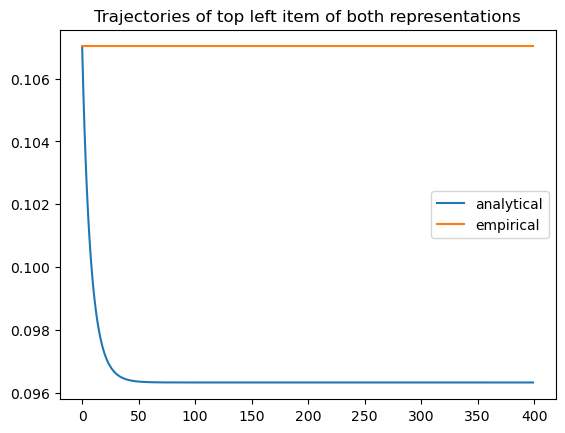

In [57]:
in_dim = 5
hidden_dim = 10
out_dim = 2

tau = 0.1
batch_size = 10
epochs = 400

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
# init_w1 = torch.tensor(init_w1)
# init_w2 = torch.tensor(init_w2)

model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)

X_train, Y_train = get_random_regression_task(batch_size, in_dim, out_dim)

w1s, w2s, losses = model.train(X_train.T, Y_train.T, epochs, tau)

analytical = QQT(init_w1, init_w2, X_train.T, Y_train.T, True)
analytical = np.asarray([analytical.forward(tau) for _ in range(epochs)])

w2w1s = [w2 @ w1 for (w2, w1) in zip(w2s, w1s)]
diffs = [np.linalg.norm(w2w1 - anal) for (w2w1, anal) in zip(w2w1s, analytical)]


top_left_empirical = [w2w1[0][0] for w2w1 in w2w1s]
top_left_analytical = [anal[0][0] for anal in analytical]

In [53]:
diffs

[3.6830512168738793e-16,
 0.00013010195763592307,
 0.000260168310921823,
 0.00039019906382767116,
 0.0005201942202746827,
 0.0006501537841356153,
 0.0007800777592342641,
 0.000909966149346612,
 0.0010398189582000955,
 0.0011696361894739074,
 0.0012994178468000118,
 0.0014291639337620928,
 0.001558874453896773,
 0.0016885494106926404,
 0.0018181888075917358,
 0.0019477926479883818,
 0.002077360935230607,
 0.002206893672619038,
 0.00233639086340853,
 0.0024658525108065014,
 0.0025952786179747243,
 0.0027246691880288784,
 0.002854024224038318,
 0.0029833437290266774,
 0.0031126277059723545,
 0.003241876157807533,
 0.0033710890874193893,
 0.0035002664976501304,
 0.0036294083912966884,
 0.003758514771110887,
 0.003887585639800298,
 0.004016621000027447,
 0.004145620854410944,
 0.0042745852055246746,
 0.004403514055898664,
 0.0045324074080187625,
 0.00466126526432721,
 0.004790087627222609,
 0.004918874499059768,
 0.005047625882150514,
 0.0051763417787631626,
 0.005305022191123109,
 0.005433